### Jupyter notebook for practice quiz for lesson 2.4.4
This Jupyter notebook simulates a battery pack comprising parallel cell modules (PCMs)

In [1]:
% add the toolbox code to Octave's path
addpath readonly
load readonly/E2model.mat;

In [2]:
% simPCM: Simulate parallel-connected-module packs (cells are connected in
% parallel to make modules; these modules are connected in series to make
% packs).
% The parameters for each cell may be different

% Initialize some pack configuration parameters...
Ns = 3;       % Number of modules connected in series to make a pack
Np = 3;       % Number of cells connected in parallel in each module

% Initialize some simulation configuration parameters...
maxtime = 3600; % Simulation run time in simulated seconds
t0 = 2700; % Pack rests after time t0
storez = zeros([maxtime Ns Np]);  % create storage for SOC
storei = zeros([maxtime Ns Np]);  % create storage for current

% Initialize states for ESC cell model
z   = 0.25*ones(Ns,Np);
irc = zeros(Ns,Np);
h   = zeros(Ns,Np);

% Default initialization for cells within the pack
T  = 25; % Temperature
q  = getParamESC('QParam',T,model)*ones(Ns,Np); 
rc = exp(-1./abs(getParamESC('RCParam',T,model)))'*ones(Ns,Np);
r  = (getParamESC('RParam',T,model))';
% In the following line, I set the hysteresis magnitudes to zero to make
% it easier to understand results. I assume this value of zero for the
% practice quiz questions. After completing the practice quiz, you can 
% use the nonzero values and see how it changes simulation results!
m  = 0*getParamESC('MParam',T,model)*ones(Ns,Np);
g  = getParamESC('GParam',T,model)*ones(Ns,Np);
r0 = getParamESC('R0Param',T,model)*ones(Ns,Np); 
rt = 0.000125; % 125 microOhm resistance for each tab

% =====================================================================
% MODIFY THIS SECTION WHEN ANSWERING THE PRACTICE QUIZ

% Modified initialization for cell variability
if 0, % set to "if 1," to execute, or "if 0," to skip this code
  z = reshape(linspace(0.3,0.8,Ns*Np),Ns,Np); % Different initial SOCs
end

if 0, % set to "if 1," to execute, or "if 0," to skip this code
  q = reshape(linspace(4.5,5.5,Ns*Np),Ns,Np); % Different capacities
end

if 1, % set to "if 1," to execute, or "if 0," to skip this code
  r0 = reshape(linspace(0.005,0.025,Ns*Np),Ns,Np); % Different R0 values
end
r0 = r0 + 2*rt; % add tab resistance to cell resistance

% END OF MODIFY SECTION
% =====================================================================

% Add faults to pack: cells faulted open- and short-circuit
% To delete a PCM (open-circuit fault), set a resistance to Inf
%r0(1,1) = Inf; % for example...

% To delete a cell from a PCM (short-circuit fault), set its SOC to NaN
%z(1,2) = NaN; % for example, delete cell 2 in PCM 1 
Rsc = 0.0025; % Resistance value to use for cell whose SOC < 0%

% ------------------------------------------------------------------------
% Get ready to simulate... first compute pack capacity in Ah
totalCap = min(sum(q,2)); % pack capacity = minimum module capacity
I = 10*totalCap; % cycle at 10C... not realistic, faster simulation

% Okay... now to simulate pack performance using ESC cell model.
for k = 1:maxtime,
  v = OCVfromSOCtemp(z,T,model); % get OCV for each cell: Ns * Np matrix
  v = v + m.*h - r.*irc; % add in capacitor voltages and hysteresis
  r0(isnan(z)) = Rsc; % short-circuit fault has "short-circuit" resistance
  V = (sum(v./r0,2) - I)./sum(1./r0,2);
  ik = (v-repmat(V,1,Np))./r0;
  z = z - (1/3600)*ik./q;  % Update each cell SOC
  z(z<0) = NaN; % set over-discharged cells to short-circuit fault
  irc = rc.*irc + (1-rc).*ik; % Update capacitor voltages
  fac = exp(-abs(g.*ik)./(3600*q));
  h = fac.*h + (fac-1).*sign(ik); % Update hysteresis voltages
  minz = min(z(:)); maxz = max(z(:)); % Check to see if SOC limit hit
  if minz < 0.05, I = -abs(I); end % stop discharging
  if maxz > 0.95, I = abs(I);  end % stop charging
  if k>t0, I = 0; end % rest 
  storez(k,:,:) = z; % Store SOC for later plotting
  storei(k,:,:) = ik; % store current for later plotting
end % for k
fprintf('Finished executing simulation. Ready to produce plots!\n')

Finished executing simulation. Ready to produce plots!


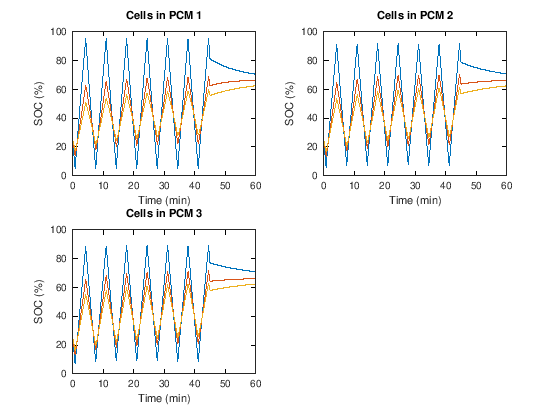

In [3]:
% Plot the individual SOC vs. time for all cells in all 
% series PCMs. There is one subplot for each PCM.
t = (0:(length(storez(:,:,1))-1))/60; 
xplots = round(1.0*ceil(sqrt(Ns))); yplots = ceil(Ns/xplots); means = [];
for k = 1:Ns,
  zr=squeeze(100*storez(:,k,:));
  subplot(yplots,xplots,k); plot(t,zr); axis([0 ceil(maxtime/60) 0 100]);
  title(sprintf('Cells in PCM %d',k)); 
  ylabel('SOC (%)'); xlabel('Time (min)'); 
end

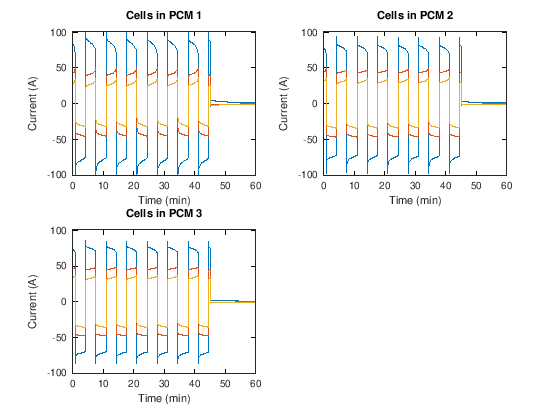

In [4]:
% Plot the individual cell current vs. time for all cells in 
% all series PCMs. There is one subplot for each PCM.
t = (0:(length(storei(:,:,1))-1))/60; 
for k = 1:Ns,
  zr=squeeze(storei(:,k,:));
  subplot(yplots,xplots,k); plot(t,zr); 
  axis([0 ceil(maxtime/60) -101 101]);
  title(sprintf('Cells in PCM %d',k)); 
  ylabel('Current (A)'); xlabel('Time (min)'); 
end